# Assignment 4: Generative Models with GAN/cGAN

**Course:** Deep Learning  
**Dataset:** Adult (Census Income)  
**Task:** Implement GAN and Conditional GAN for synthetic tabular data generation

---

## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F  # Added for correlation_loss
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Using device: cuda


## 2. Data Loading and Preprocessing

### 2.1 Load ARFF File

In [2]:
# Load the Adult dataset from ARFF file
data, meta = arff.loadarff('adult.arff')
df = pd.DataFrame(data)

# Decode byte strings to regular strings
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()

Dataset shape: (32561, 15)

Column types:
age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
income             object
dtype: object

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
# Check for missing values (represented as '?')
print("Missing values ('?') per column:")
for col in df.columns:
    if df[col].dtype == object:
        missing_count = (df[col] == '?').sum()
        if missing_count > 0:
            print(f"  {col}: {missing_count} ({missing_count/len(df)*100:.2f}%)")

Missing values ('?') per column:
  workclass: 1836 (5.64%)
  occupation: 1843 (5.66%)
  native-country: 583 (1.79%)


### 2.2 Preprocessing

**Preprocessing decisions:**
1. **Missing values**: Impute using mode for categorical features (most frequent value)
2. **Skewed features**: Log transform (log1p) for `capital-gain` and `capital-loss` to handle zero-inflation
3. **Continuous features**: Min-Max scaling to [0, 1] range (after log transform)
4. **Categorical features**: One-hot encoding

In [4]:
# Define feature types
# NOTE: education-num moved to categorical because it's discrete (education levels)
CONTINUOUS_COLS = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
CATEGORICAL_COLS = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country', 'education-num']
TARGET_COL = 'income'

print(f"Continuous features ({len(CONTINUOUS_COLS)}): {CONTINUOUS_COLS}")
print(f"Categorical features ({len(CATEGORICAL_COLS)}): {CATEGORICAL_COLS}")
print(f"Target: {TARGET_COL}")
print("\nNOTE: education-num is now treated as categorical (discrete values)")


Continuous features (5): ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features (9): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'education-num']
Target: income

NOTE: education-num is now treated as categorical (discrete values)


In [5]:
from sklearn.mixture import GaussianMixture

class VGMTransformer:
    """Variational Gaussian Mixture transformation with ZERO and PEAK inflation handling.

    Handles three types of continuous features:
    1. Zero-inflated (capital-gain, capital-loss): ~90% zeros
    2. Peak-inflated (hours-per-week): ~47% at value 40
    3. Regular continuous (age, fnlwgt): standard VGM

    Output format varies by type:
    - Zero-inflated: (is_zero, normalized_value, mode_one_hot)
    - Peak-inflated: (is_peak, normalized_value, mode_one_hot)
    - Regular: (normalized_value, mode_one_hot)
    """

    def __init__(self, n_modes=5, zero_inflated_cols=None, peak_inflated_cols=None):
        self.n_modes = n_modes
        self.zero_inflated_cols = zero_inflated_cols or []
        self.peak_inflated_cols = peak_inflated_cols or {}  # {col_name: peak_value}
        self.gmms = {}
        self.fitted = False

    def fit(self, df, continuous_cols):
        """Fit GMM to each continuous column."""
        for col in continuous_cols:
            values = df[col].values

            if col in self.zero_inflated_cols:
                # Fit GMM only on non-zero values
                nonzero_mask = values != 0
                if nonzero_mask.sum() > self.n_modes:
                    fit_values = values[nonzero_mask].reshape(-1, 1)
                else:
                    fit_values = values.reshape(-1, 1)
            elif col in self.peak_inflated_cols:
                # Fit GMM only on non-peak values
                peak_val = self.peak_inflated_cols[col]
                nonpeak_mask = values != peak_val
                if nonpeak_mask.sum() > self.n_modes:
                    fit_values = values[nonpeak_mask].reshape(-1, 1)
                else:
                    fit_values = values.reshape(-1, 1)
            else:
                fit_values = values.reshape(-1, 1)

            gmm = GaussianMixture(
                n_components=self.n_modes,
                random_state=42,
                covariance_type='full'
            )
            gmm.fit(fit_values)
            self.gmms[col] = gmm

        self.continuous_cols = continuous_cols
        self.fitted = True
        return self

    def transform(self, df, continuous_cols):
        """Transform continuous features with zero/peak inflation awareness."""
        if not self.fitted:
            raise ValueError("VGMTransformer must be fitted before transform")

        results = []
        for col in continuous_cols:
            gmm = self.gmms[col]
            values = df[col].values

            if col in self.zero_inflated_cols:
                # Zero-inflation handling
                is_special = (values == 0).astype(np.float32).reshape(-1, 1)
                values_for_gmm = np.where(values == 0, 1e-6, values).reshape(-1, 1)

            elif col in self.peak_inflated_cols:
                # Peak-inflation handling
                peak_val = self.peak_inflated_cols[col]
                is_special = (values == peak_val).astype(np.float32).reshape(-1, 1)
                # For peak values, use the peak value for GMM (will be masked anyway)
                values_for_gmm = values.reshape(-1, 1)

            else:
                is_special = None
                values_for_gmm = values.reshape(-1, 1)

            # Get mode assignments
            mode_idx = gmm.predict(values_for_gmm)
            means = gmm.means_.flatten()
            stds = np.sqrt(gmm.covariances_.reshape(self.n_modes, -1)[:, 0])

            # Normalize within mode
            normalized = np.zeros(len(values))
            for m in range(self.n_modes):
                mask = (mode_idx == m)
                if mask.sum() > 0:
                    normalized[mask] = ((values_for_gmm[mask].flatten() - means[m]) /
                                       (4 * stds[m] + 1e-8))

            # For special values (zero/peak), set normalized to 0
            if col in self.zero_inflated_cols:
                normalized = np.where(values == 0, 0, normalized)
            elif col in self.peak_inflated_cols:
                peak_val = self.peak_inflated_cols[col]
                normalized = np.where(values == peak_val, 0, normalized)

            normalized = np.clip(normalized, -0.99, 0.99).reshape(-1, 1)
            mode_onehot = np.eye(self.n_modes)[mode_idx]

            if is_special is not None:
                # Output: [is_special, normalized_value, mode_one_hot]
                feature_data = np.column_stack([is_special, normalized, mode_onehot])
            else:
                # Output: [normalized_value, mode_one_hot]
                feature_data = np.column_stack([normalized, mode_onehot])

            results.append(feature_data)

        return np.hstack(results).astype(np.float32)

    def inverse_transform(self, data, continuous_cols):
        """Inverse transform with zero/peak inflation handling."""
        results = []
        pos = 0

        for col in continuous_cols:
            gmm = self.gmms[col]
            means = gmm.means_.flatten()
            stds = np.sqrt(gmm.covariances_.reshape(self.n_modes, -1)[:, 0])

            if col in self.zero_inflated_cols or col in self.peak_inflated_cols:
                # Extract is_special, normalized, mode_onehot
                is_special = data[:, pos]
                normalized = data[:, pos + 1]
                mode_onehot = data[:, pos + 2:pos + 2 + self.n_modes]
                pos += 2 + self.n_modes

                mode_idx = np.argmax(mode_onehot, axis=1)

                # Denormalize
                values = np.zeros(len(normalized))
                for m in range(self.n_modes):
                    mask = (mode_idx == m)
                    if mask.sum() > 0:
                        values[mask] = normalized[mask] * (4 * stds[m]) + means[m]

                # Apply special value mask
                if col in self.zero_inflated_cols:
                    values = np.where(is_special > 0.5, 0, values)
                    values = np.maximum(values, 0)  # Ensure non-negative
                elif col in self.peak_inflated_cols:
                    peak_val = self.peak_inflated_cols[col]
                    values = np.where(is_special > 0.5, peak_val, values)

            else:
                # Regular VGM inverse
                normalized = data[:, pos]
                mode_onehot = data[:, pos + 1:pos + 1 + self.n_modes]
                pos += 1 + self.n_modes

                mode_idx = np.argmax(mode_onehot, axis=1)

                values = np.zeros(len(normalized))
                for m in range(self.n_modes):
                    mask = (mode_idx == m)
                    if mask.sum() > 0:
                        values[mask] = normalized[mask] * (4 * stds[m]) + means[m]

            results.append(values.reshape(-1, 1))

        return np.hstack(results)

    def get_output_dim(self, continuous_cols):
        """Get output dimension for continuous features after VGM transform."""
        dim = 0
        for col in continuous_cols:
            if col in self.zero_inflated_cols or col in self.peak_inflated_cols:
                dim += 2 + self.n_modes  # is_special + value + modes
            else:
                dim += 1 + self.n_modes  # value + modes
        return dim

    def get_feature_structure(self, continuous_cols):
        """Get structure info for Generator output formatting."""
        structure = []
        for col in continuous_cols:
            if col in self.zero_inflated_cols:
                structure.append({
                    'name': col,
                    'type': 'zero_inflated',
                    'dim': 2 + self.n_modes,
                    'special_value': 0
                })
            elif col in self.peak_inflated_cols:
                structure.append({
                    'name': col,
                    'type': 'peak_inflated',
                    'dim': 2 + self.n_modes,
                    'special_value': self.peak_inflated_cols[col]
                })
            else:
                structure.append({
                    'name': col,
                    'type': 'regular',
                    'dim': 1 + self.n_modes,
                    'special_value': None
                })
        return structure


In [6]:
class DataPreprocessor:
    """Preprocessor with ZERO-INFLATION, PEAK-INFLATION, and discrete handling.

    Key improvements:
    1. Zero-inflation for capital-gain, capital-loss (~90% zeros)
    2. Peak-inflation for hours-per-week (~47% at 40)
    3. education-num treated as categorical (discrete values)
    """

    def __init__(self, continuous_cols, categorical_cols, target_col,
                 n_modes=5, rare_threshold=0.01):
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.n_modes = n_modes
        self.rare_threshold = rare_threshold

        # Special feature handling
        self.zero_inflated_cols = ['capital-gain', 'capital-loss']
        self.peak_inflated_cols = {'hours-per-week': 40.0}  # 46.7% at 40

        # Transformers
        self.vgm = VGMTransformer(
            n_modes=n_modes,
            zero_inflated_cols=self.zero_inflated_cols,
            peak_inflated_cols=self.peak_inflated_cols
        )
        self.label_encoder = LabelEncoder()

        # Mappings
        self.category_mappings = {}
        self.category_dims = {}
        self.mode_values = {}
        self.rare_categories = {}

    def _group_rare_categories(self, df):
        """Group rare categories (<rare_threshold frequency) into 'Other'."""
        df = df.copy()
        for col in self.categorical_cols:
            # Convert to string for education-num (it's numeric but categorical)
            if col == 'education-num':
                df[col] = df[col].astype(str)
            freq = df[col].value_counts(normalize=True)
            rare_cats = freq[freq < self.rare_threshold].index.tolist()
            self.rare_categories[col] = rare_cats
            if rare_cats:
                df[col] = df[col].replace(rare_cats, 'Other')
        return df

    def _apply_rare_grouping(self, df):
        """Apply pre-fitted rare category grouping."""
        df = df.copy()
        for col in self.categorical_cols:
            if col == 'education-num':
                df[col] = df[col].astype(str)
            if col in self.rare_categories:
                df[col] = df[col].replace(self.rare_categories[col], 'Other')
        return df

    def fit(self, df):
        """Fit the preprocessor on training data."""
        df = df.copy()

        # Convert education-num to string for categorical treatment
        if 'education-num' in self.categorical_cols:
            df['education-num'] = df['education-num'].astype(str)

        # Store mode values for imputation
        for col in self.categorical_cols:
            if df[col].dtype == object or col == 'education-num':
                valid_values = df[df[col] != '?'][col]
                if len(valid_values) > 0:
                    self.mode_values[col] = valid_values.mode()[0]

        # Impute missing values
        for col in self.categorical_cols:
            if col in self.mode_values:
                df[col] = df[col].replace('?', self.mode_values[col])

        # Group rare categories
        df = self._group_rare_categories(df)

        # Apply log transform to zero-inflated columns (only to non-zero values)
        for col in self.zero_inflated_cols:
            if col in self.continuous_cols:
                df[col] = np.where(df[col] > 0, np.log1p(df[col]), 0)

        # Fit VGM on continuous features
        self.vgm.fit(df, self.continuous_cols)

        # Fit label encoder on target
        self.label_encoder.fit(df[self.target_col])

        # Store category mappings
        for col in self.categorical_cols:
            unique_values = sorted(df[col].unique())
            self.category_mappings[col] = {v: i for i, v in enumerate(unique_values)}
            self.category_dims[col] = len(unique_values)

        return self

    def transform(self, df):
        """Transform data using fitted preprocessor."""
        df = df.copy()

        # Convert education-num to string
        if 'education-num' in self.categorical_cols:
            df['education-num'] = df['education-num'].astype(str)

        # Impute missing values
        for col in self.categorical_cols:
            if col in self.mode_values:
                df[col] = df[col].replace('?', self.mode_values[col])

        # Apply rare category grouping
        df = self._apply_rare_grouping(df)

        # Apply log transform to zero-inflated columns
        for col in self.zero_inflated_cols:
            if col in self.continuous_cols:
                df[col] = np.where(df[col] > 0, np.log1p(df[col]), 0)

        # Transform continuous features with VGM
        continuous_data = self.vgm.transform(df, self.continuous_cols)

        # One-hot encode categorical features
        categorical_data = []
        for col in self.categorical_cols:
            one_hot = np.zeros((len(df), self.category_dims[col]))
            for i, val in enumerate(df[col]):
                if val in self.category_mappings[col]:
                    one_hot[i, self.category_mappings[col][val]] = 1
                else:
                    if 'Other' in self.category_mappings[col]:
                        one_hot[i, self.category_mappings[col]['Other']] = 1
                    else:
                        one_hot[i, 0] = 1
            categorical_data.append(one_hot)

        categorical_data = np.hstack(categorical_data)

        # Encode target
        target = self.label_encoder.transform(df[self.target_col])

        # Combine all features
        X = np.hstack([continuous_data, categorical_data])
        y = target

        return X.astype(np.float32), y.astype(np.int64)

    def inverse_transform(self, X):
        """Convert processed data back to original format."""
        vgm_dim = self.get_continuous_dim()

        vgm_data = X[:, :vgm_dim]
        categorical_data = X[:, vgm_dim:]

        # Inverse VGM transform
        continuous_unscaled = self.vgm.inverse_transform(vgm_data, self.continuous_cols)
        continuous_df = pd.DataFrame(continuous_unscaled, columns=self.continuous_cols)

        # Inverse log transform for zero-inflated columns
        for col in self.zero_inflated_cols:
            if col in self.continuous_cols:
                continuous_df[col] = np.where(
                    continuous_df[col] > 0,
                    np.expm1(continuous_df[col]),
                    0
                )

        # Decode categorical features
        categorical_df = pd.DataFrame()
        idx = 0
        for col in self.categorical_cols:
            dim = self.category_dims[col]
            one_hot = categorical_data[:, idx:idx+dim]
            cat_indices = np.argmax(one_hot, axis=1)
            reverse_mapping = {v: k for k, v in self.category_mappings[col].items()}
            categorical_df[col] = [reverse_mapping.get(i, 'Unknown') for i in cat_indices]
            idx += dim

        return pd.concat([continuous_df, categorical_df], axis=1)

    def get_output_dim(self):
        """Get total dimension of processed features."""
        vgm_dim = self.vgm.get_output_dim(self.continuous_cols)
        cat_dim = sum(self.category_dims.values())
        return vgm_dim + cat_dim

    def get_continuous_dim(self):
        """Get dimension of continuous features after VGM."""
        return self.vgm.get_output_dim(self.continuous_cols)

    def get_raw_continuous_dim(self):
        """Get number of raw continuous features."""
        return len(self.continuous_cols)

    def get_categorical_dims(self):
        """Get list of dimensions for each categorical feature."""
        return [self.category_dims[col] for col in self.categorical_cols]

    def get_n_modes(self):
        """Get number of modes used in VGM."""
        return self.n_modes

    def get_feature_structure(self):
        """Get feature structure for Generator."""
        return self.vgm.get_feature_structure(self.continuous_cols)

    def get_special_cols(self):
        """Get zero-inflated and peak-inflated column names."""
        return {
            'zero_inflated': self.zero_inflated_cols,
            'peak_inflated': list(self.peak_inflated_cols.keys())
        }


In [7]:
# Initialize preprocessor with VGM and rare category grouping
# Note: This is for initial testing. Experiments re-initialize with config values.
preprocessor = DataPreprocessor(
    CONTINUOUS_COLS, 
    CATEGORICAL_COLS, 
    TARGET_COL,
    n_modes=5,           # 5 modes for VGM (same as N_MODES in config)
    rare_threshold=0.01  # Group categories with <1% frequency
)
preprocessor.fit(df)

print(f"Total feature dimension: {preprocessor.get_output_dim()}")
print(f"VGM continuous dimension: {preprocessor.get_continuous_dim()} (includes mode indicators)")
print(f"Raw continuous features: {preprocessor.get_raw_continuous_dim()}")
print(f"Categorical dimensions: {preprocessor.get_categorical_dims()}")
print(f"Number of modes per feature: {preprocessor.get_n_modes()}")
print(f"Rare categories grouped as 'Other':" )
for col, rare in preprocessor.rare_categories.items():
    if rare:
        print(f"  {col}: {len(rare)} categories grouped")

Total feature dimension: 105
VGM continuous dimension: 33 (includes mode indicators)
Raw continuous features: 5
Categorical dimensions: [7, 15, 7, 13, 6, 4, 2, 3, 15]
Number of modes per feature: 5
Rare categories grouped as 'Other':
  workclass: 2 categories grouped
  education: 2 categories grouped
  marital-status: 1 categories grouped
  occupation: 2 categories grouped
  race: 2 categories grouped
  native-country: 39 categories grouped
  education-num: 2 categories grouped


### 2.3 Train-Test Split

In [8]:
def prepare_data(df, preprocessor, seed=42, test_size=0.2):
    """Prepare train and test data with stratified split."""
    # Split before preprocessing to avoid data leakage
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=seed, stratify=df[TARGET_COL]
    )
    
    # Fit preprocessor only on training data
    preprocessor_local = DataPreprocessor(CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL)
    preprocessor_local.fit(train_df)
    
    # Transform both sets
    X_train, y_train = preprocessor_local.transform(train_df)
    X_test, y_test = preprocessor_local.transform(test_df)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Label distribution (train): {np.bincount(y_train) / len(y_train)}")
    print(f"Label distribution (test): {np.bincount(y_test) / len(y_test)}")
    
    return X_train, X_test, y_train, y_test, preprocessor_local

# Test with seed 42
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, preprocessor, seed=42)

Training set: 26048 samples
Test set: 6513 samples
Label distribution (train): [0.75917537 0.24082463]
Label distribution (test): [0.75925073 0.24074927]


---

## 3. GAN Architecture (WGAN-GP with Improvements)

We implement a WGAN-GP with key improvements for tabular data:

**Key Improvements:**
1. **Gumbel-Softmax**: Hard one-hot categorical outputs with differentiable sampling
2. **WGAN-GP Loss**: Wasserstein loss with gradient penalty for stable training
3. **Minibatch Discrimination**: Computes pairwise similarities in batch to encourage diversity
4. **Zero-Inflated Feature Handling**: Separate "is_zero" prediction for capital-gain/loss (91-95% zeros)
5. **Supervised Training**: GAN also uses labels during training for better feature-label correlation
6. **Spectral Normalization + TTUR**: Stabilized discriminator and learning rate balance

**Generator:**
- MLP with LayerNorm and LeakyReLU
- Continuous features: Sigmoid + zero-mask for inflated features
- Categorical features: Gumbel-Softmax with straight-through estimator

**Discriminator (Critic):**
- MLP with Spectral Normalization
- Minibatch discrimination layer for diversity
- No Sigmoid (Wasserstein loss)

In [9]:
# Gumbel-Softmax for differentiable discrete sampling
def gumbel_softmax(logits, temperature=0.2, hard=True):
    """Gumbel-Softmax with optional straight-through gradient."""
    gumbels = -torch.log(-torch.log(torch.rand_like(logits) + 1e-20) + 1e-20)
    y_soft = torch.softmax((logits + gumbels) / temperature, dim=-1)

    if hard:
        index = y_soft.max(dim=-1, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(-1, index, 1.0)
        return y_hard - y_soft.detach() + y_soft
    return y_soft


def weights_init(m):
    """Custom weight initialization for Generator."""
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


class MinibatchDiscrimination(nn.Module):
    """Minibatch discrimination layer to prevent mode collapse."""
    def __init__(self, in_features, out_features, kernel_dim):
        super().__init__()
        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dim))

    def forward(self, x):
        M = torch.mm(x, self.T.view(self.T.size(0), -1))
        M = M.view(-1, self.T.size(1), self.T.size(2))

        M_expanded = M.unsqueeze(0)
        M_transposed = M.unsqueeze(1)

        diffs = torch.abs(M_expanded - M_transposed).sum(dim=3)
        diffs = torch.exp(-diffs)

        o = diffs.sum(dim=0) - 1
        return o


class Generator(nn.Module):
    """Generator with ZERO and PEAK inflation handling.

    Handles three types of continuous features:
    - zero_inflated: (is_zero_prob, normalized_value, mode_one_hot)
    - peak_inflated: (is_peak_prob, normalized_value, mode_one_hot)
    - regular: (normalized_value, mode_one_hot)
    """

    def __init__(self, latent_dim, feature_structure, categorical_dims,
                 hidden_dim=128, temperature=0.2, n_modes=5):
        super().__init__()
        self.feature_structure = feature_structure
        self.categorical_dims = categorical_dims
        self.temperature = temperature
        self.n_modes = n_modes

        # Calculate output dimension
        self.continuous_output_dim = sum(f['dim'] for f in feature_structure)
        output_dim = self.continuous_output_dim + sum(categorical_dims)

        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, output_dim)
        )

    def forward(self, z, hard=True):
        x = self.main(z)

        outputs = []
        pos = 0

        # Process continuous features
        for feat in self.feature_structure:
            if feat['type'] in ['zero_inflated', 'peak_inflated']:
                # Special value handling (is_special, value, mode)
                is_special_logit = x[:, pos:pos+1]
                is_special_prob = torch.sigmoid(is_special_logit)
                pos += 1

                value = torch.tanh(x[:, pos:pos+1])
                pos += 1

                mode_logits = x[:, pos:pos+self.n_modes]
                mode_onehot = gumbel_softmax(mode_logits, self.temperature, hard)
                pos += self.n_modes

                if hard:
                    is_special_hard = (is_special_prob > 0.5).float()
                    is_special_out = is_special_hard - is_special_prob.detach() + is_special_prob
                else:
                    is_special_out = is_special_prob

                outputs.extend([is_special_out, value, mode_onehot])
            else:
                # Regular continuous
                value = torch.tanh(x[:, pos:pos+1])
                pos += 1

                mode_logits = x[:, pos:pos+self.n_modes]
                mode_onehot = gumbel_softmax(mode_logits, self.temperature, hard)
                pos += self.n_modes

                outputs.extend([value, mode_onehot])

        # Process categorical features
        for dim in self.categorical_dims:
            cat_logits = x[:, pos:pos+dim]
            cat_samples = gumbel_softmax(cat_logits, self.temperature, hard)
            outputs.append(cat_samples)
            pos += dim

        return torch.cat(outputs, dim=1)


class Discriminator(nn.Module):
    """WGAN-GP Discriminator with increased regularization."""

    def __init__(self, input_dim, hidden_dim=128, dropout=0.5, use_minibatch_disc=True):
        super().__init__()
        self.use_minibatch_disc = use_minibatch_disc

        self.features = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
        )

        if use_minibatch_disc:
            self.mb_disc = MinibatchDiscrimination(hidden_dim, 32, 3)
            final_dim = hidden_dim + 32
        else:
            final_dim = hidden_dim

        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(final_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        feat = self.features(x)
        if self.use_minibatch_disc:
            mb_feat = self.mb_disc(feat)
            feat = torch.cat([feat, mb_feat], dim=1)
        return self.classifier(feat)


def gradient_penalty(discriminator, real_data, fake_data, device, labels=None):
    """Compute gradient penalty for WGAN-GP."""
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)

    if labels is not None:
        d_out = discriminator(interpolated, labels)
    else:
        d_out = discriminator(interpolated)

    grads = torch.autograd.grad(d_out, interpolated, torch.ones_like(d_out),
                                 create_graph=True, retain_graph=True)[0]
    return ((grads.view(batch_size, -1).norm(2, dim=1) - 1) ** 2).mean()


def correlation_loss(real, fake, feature_structure, n_modes):
    """Compute correlation loss between real and fake continuous features."""
    real_values = []
    fake_values = []
    pos = 0

    for feat in feature_structure:
        if feat['type'] in ['zero_inflated', 'peak_inflated']:
            real_values.append(real[:, pos + 1:pos + 2])
            fake_values.append(fake[:, pos + 1:pos + 2])
            pos += 2 + n_modes
        else:
            real_values.append(real[:, pos:pos + 1])
            fake_values.append(fake[:, pos:pos + 1])
            pos += 1 + n_modes

    real_cont = torch.cat(real_values, dim=1)
    fake_cont = torch.cat(fake_values, dim=1)

    real_std = (real_cont - real_cont.mean(0)) / (real_cont.std(0) + 1e-8)
    fake_std = (fake_cont - fake_cont.mean(0)) / (fake_cont.std(0) + 1e-8)

    r_corr = torch.mm(real_std.t(), real_std) / real_std.size(0)
    f_corr = torch.mm(fake_std.t(), fake_std) / fake_std.size(0)

    return F.mse_loss(f_corr, r_corr)


def special_proportion_loss(real, fake, feature_structure, n_modes):
    """Loss to match proportion of special values (zeros and peaks)."""
    loss = 0
    pos = 0
    count = 0

    for feat in feature_structure:
        if feat['type'] in ['zero_inflated', 'peak_inflated']:
            real_is_special = real[:, pos]
            fake_is_special = fake[:, pos]

            real_prop = real_is_special.mean()
            fake_prop = fake_is_special.mean()

            loss += (real_prop - fake_prop) ** 2
            count += 1
            pos += 2 + n_modes
        else:
            pos += 1 + n_modes

    return loss / max(count, 1)


---

## 4. Conditional GAN (cGAN) Architecture

The cGAN extends the WGAN-GP by conditioning on the target label:
- **Generator**: Receives noise + one-hot label, uses Gumbel-Softmax for categorical outputs
- **Discriminator**: Receives data + one-hot label, uses Spectral Normalization

Same improvements as the unconditional GAN:
- WGAN-GP loss with gradient penalty
- Gumbel-Softmax for hard categorical sampling
- TTUR learning rate schedule

In [10]:
class ConditionalGenerator(nn.Module):
    """Conditional Generator with ZERO and PEAK inflation handling."""

    def __init__(self, latent_dim, num_classes, feature_structure, categorical_dims,
                 hidden_dim=128, temperature=0.2, n_modes=5):
        super(ConditionalGenerator, self).__init__()

        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.feature_structure = feature_structure
        self.categorical_dims = categorical_dims
        self.temperature = temperature
        self.n_modes = n_modes

        input_dim = latent_dim + num_classes
        self.continuous_output_dim = sum(f['dim'] for f in feature_structure)
        output_dim = self.continuous_output_dim + sum(categorical_dims)

        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, output_dim)
        )

    def forward(self, z, labels, hard=True):
        if labels.dim() == 1:
            labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=z.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        else:
            labels_onehot = labels

        x = torch.cat([z, labels_onehot], dim=1)
        x = self.main(x)

        outputs = []
        pos = 0

        for feat in self.feature_structure:
            if feat['type'] in ['zero_inflated', 'peak_inflated']:
                is_special_logit = x[:, pos:pos+1]
                is_special_prob = torch.sigmoid(is_special_logit)
                pos += 1

                value = torch.tanh(x[:, pos:pos+1])
                pos += 1

                mode_logits = x[:, pos:pos+self.n_modes]
                mode_onehot = gumbel_softmax(mode_logits, self.temperature, hard)
                pos += self.n_modes

                if hard:
                    is_special_hard = (is_special_prob > 0.5).float()
                    is_special_out = is_special_hard - is_special_prob.detach() + is_special_prob
                else:
                    is_special_out = is_special_prob

                outputs.extend([is_special_out, value, mode_onehot])
            else:
                value = torch.tanh(x[:, pos:pos+1])
                pos += 1

                mode_logits = x[:, pos:pos+self.n_modes]
                mode_onehot = gumbel_softmax(mode_logits, self.temperature, hard)
                pos += self.n_modes

                outputs.extend([value, mode_onehot])

        for dim in self.categorical_dims:
            cat_logits = x[:, pos:pos+dim]
            cat_samples = gumbel_softmax(cat_logits, self.temperature, hard)
            outputs.append(cat_samples)
            pos += dim

        return torch.cat(outputs, dim=1)


class ConditionalDiscriminator(nn.Module):
    """WGAN-GP Conditional Discriminator with increased regularization."""

    def __init__(self, input_dim, num_classes, hidden_dim=128, dropout=0.5,
                 use_minibatch_disc=True):
        super(ConditionalDiscriminator, self).__init__()

        self.num_classes = num_classes
        self.use_minibatch_disc = use_minibatch_disc

        total_input_dim = input_dim + num_classes

        self.features = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(total_input_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
        )

        if use_minibatch_disc:
            self.mb_disc = MinibatchDiscrimination(hidden_dim, 32, 3)
            final_dim = hidden_dim + 32
        else:
            final_dim = hidden_dim

        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(final_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x, labels):
        if labels.dim() == 1:
            labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=x.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        else:
            labels_onehot = labels

        x = torch.cat([x, labels_onehot], dim=1)
        feat = self.features(x)

        if self.use_minibatch_disc:
            mb_feat = self.mb_disc(feat)
            feat = torch.cat([feat, mb_feat], dim=1)

        return self.classifier(feat)


---

## 5. Training Functions

In [11]:
def train_gan(X_train, preprocessor, latent_dim=128, hidden_dim=128,
              batch_size=128, epochs=500, lr_g=0.0002, lr_d=0.0001,
              n_critic=5, lambda_gp=10, lambda_corr=0.1, lambda_special=0.5,
              temperature=0.2, dropout=0.5, instance_noise=0.15, seed=42,
              save_dir='plots/gan'):
    """
    Train WGAN-GP with zero/peak inflation handling.
    """
    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)

    feature_structure = preprocessor.get_feature_structure()
    n_modes = preprocessor.get_n_modes()
    categorical_dims = preprocessor.get_categorical_dims()
    data_dim = preprocessor.get_output_dim()

    generator = Generator(
        latent_dim=latent_dim,
        feature_structure=feature_structure,
        categorical_dims=categorical_dims,
        hidden_dim=hidden_dim,
        temperature=temperature,
        n_modes=n_modes
    ).to(device)

    discriminator = Discriminator(
        input_dim=data_dim,
        hidden_dim=hidden_dim,
        dropout=dropout,
        use_minibatch_disc=True
    ).to(device)

    generator.apply(weights_init)

    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))

    dataset = TensorDataset(torch.FloatTensor(X_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    g_losses = []
    d_losses = []

    for epoch in tqdm(range(epochs), desc="Training WGAN-GP"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        g_updates = 0

        current_noise_std = instance_noise * max(0, 1 - epoch / (epochs * 0.8))

        for batch_idx, (real_data,) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)

            if current_noise_std > 0:
                real_data_noisy = real_data + torch.randn_like(real_data) * current_noise_std
            else:
                real_data_noisy = real_data

            optimizer_d.zero_grad()
            d_real = discriminator(real_data_noisy)

            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z)

            if current_noise_std > 0:
                fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
            else:
                fake_data_noisy = fake_data

            d_fake = discriminator(fake_data_noisy.detach())
            gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device)

            d_loss = d_fake.mean() - 0.9 * d_real.mean() + lambda_gp * gp
            d_loss.backward()
            optimizer_d.step()

            epoch_d_loss += d_loss.item()
            n_batches += 1

            if (batch_idx + 1) % n_critic == 0:
                optimizer_g.zero_grad()

                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z)

                if current_noise_std > 0:
                    fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
                else:
                    fake_data_noisy = fake_data

                d_fake = discriminator(fake_data_noisy)

                g_loss_wgan = -d_fake.mean()
                corr_loss = correlation_loss(real_data, fake_data, feature_structure, n_modes)
                special_loss = special_proportion_loss(real_data, fake_data, feature_structure, n_modes)

                g_loss = g_loss_wgan + lambda_corr * corr_loss + lambda_special * special_loss
                g_loss.backward()

                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                optimizer_g.step()

                epoch_g_loss += g_loss.item()
                g_updates += 1

        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / max(g_updates, 1))

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D_loss: {d_losses[-1]:.4f} G_loss: {g_losses[-1]:.4f}")

    return generator, g_losses, d_losses


In [12]:
def train_cgan(X_train, y_train, preprocessor, latent_dim=128, hidden_dim=128,
               batch_size=128, epochs=500, lr_g=0.0002, lr_d=0.0001,
               n_critic=5, lambda_gp=10, lambda_corr=0.1, lambda_special=0.5,
               temperature=0.2, dropout=0.5, instance_noise=0.15, seed=42,
               save_dir='plots/cgan'):
    """
    Train Conditional WGAN-GP with zero/peak inflation handling.
    """
    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)

    feature_structure = preprocessor.get_feature_structure()
    n_modes = preprocessor.get_n_modes()
    categorical_dims = preprocessor.get_categorical_dims()
    data_dim = preprocessor.get_output_dim()
    num_classes = len(np.unique(y_train))

    generator = ConditionalGenerator(
        latent_dim=latent_dim,
        num_classes=num_classes,
        feature_structure=feature_structure,
        categorical_dims=categorical_dims,
        hidden_dim=hidden_dim,
        temperature=temperature,
        n_modes=n_modes
    ).to(device)

    discriminator = ConditionalDiscriminator(
        input_dim=data_dim,
        num_classes=num_classes,
        hidden_dim=hidden_dim,
        dropout=dropout,
        use_minibatch_disc=True
    ).to(device)

    generator.apply(weights_init)

    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))

    dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    g_losses = []
    d_losses = []

    for epoch in tqdm(range(epochs), desc="Training cWGAN-GP"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        g_updates = 0

        current_noise_std = instance_noise * max(0, 1 - epoch / (epochs * 0.8))

        for batch_idx, (real_data, labels) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)
            labels = labels.to(device)

            if current_noise_std > 0:
                real_data_noisy = real_data + torch.randn_like(real_data) * current_noise_std
            else:
                real_data_noisy = real_data

            optimizer_d.zero_grad()
            d_real = discriminator(real_data_noisy, labels)

            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z, labels)

            if current_noise_std > 0:
                fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
            else:
                fake_data_noisy = fake_data

            d_fake = discriminator(fake_data_noisy.detach(), labels)
            gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device, labels)

            d_loss = d_fake.mean() - 0.9 * d_real.mean() + lambda_gp * gp
            d_loss.backward()
            optimizer_d.step()

            epoch_d_loss += d_loss.item()
            n_batches += 1

            if (batch_idx + 1) % n_critic == 0:
                optimizer_g.zero_grad()

                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z, labels)

                if current_noise_std > 0:
                    fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
                else:
                    fake_data_noisy = fake_data

                d_fake = discriminator(fake_data_noisy, labels)

                g_loss_wgan = -d_fake.mean()
                corr_loss = correlation_loss(real_data, fake_data, feature_structure, n_modes)
                special_loss = special_proportion_loss(real_data, fake_data, feature_structure, n_modes)

                g_loss = g_loss_wgan + lambda_corr * corr_loss + lambda_special * special_loss
                g_loss.backward()

                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                optimizer_g.step()

                epoch_g_loss += g_loss.item()
                g_updates += 1

        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / max(g_updates, 1))

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D_loss: {d_losses[-1]:.4f} G_loss: {g_losses[-1]:.4f}")

    return generator, g_losses, d_losses


---

## 6. Synthetic Data Generation

In [13]:
def generate_synthetic_data(generator, n_samples, latent_dim, device):
    """Generate synthetic data using trained GAN."""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        # Use hard=True for discrete one-hot outputs during generation
        synthetic_data = generator(z, hard=True)
    return synthetic_data.cpu().numpy()


def generate_conditional_synthetic_data(generator, n_samples, latent_dim, label_ratios, device):
    """Generate synthetic data using trained cGAN with specified label ratios.
    
    Args:
        generator: Trained conditional generator
        n_samples: Total number of samples to generate
        latent_dim: Dimension of latent space
        label_ratios: Array of ratios for each class (e.g., [0.75, 0.25])
        device: torch device
    
    Returns:
        synthetic_data: Generated data as numpy array
        synthetic_labels: Labels for generated data
    """
    generator.eval()
    
    # Calculate number of samples per class
    samples_per_class = (np.array(label_ratios) * n_samples).astype(int)
    # Adjust for rounding errors
    samples_per_class[-1] = n_samples - samples_per_class[:-1].sum()
    
    all_data = []
    all_labels = []
    
    with torch.no_grad():
        for label, n in enumerate(samples_per_class):
            if n > 0:
                z = torch.randn(n, latent_dim, device=device)
                labels = torch.full((n,), label, dtype=torch.long, device=device)
                # Use hard=True for discrete one-hot outputs
                synthetic = generator(z, labels, hard=True)
                all_data.append(synthetic.cpu().numpy())
                all_labels.append(np.full(n, label))
    
    return np.vstack(all_data), np.concatenate(all_labels)

---

## 7. Evaluation Metrics

In [14]:
def compute_detection_metric(X_real, X_synthetic, n_folds=4, seed=42):
    """
    Compute detection metric using Random Forest.
    
    Lower AUC (closer to 0.5) is better - means synthetic data is indistinguishable.
    
    Args:
        X_real: Real training data
        X_synthetic: Synthetic data (same size as X_real)
        n_folds: Number of folds for cross-validation
        seed: Random seed
    
    Returns:
        mean_auc: Average AUC across folds
        std_auc: Standard deviation of AUC
    """
    # Create labels: 0 for real, 1 for synthetic
    y_real = np.zeros(len(X_real))
    y_synthetic = np.ones(len(X_synthetic))
    
    # Combine data
    X_combined = np.vstack([X_real, X_synthetic])
    y_combined = np.concatenate([y_real, y_synthetic])
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    auc_scores = []
    
    for train_idx, test_idx in kfold.split(X_combined, y_combined):
        X_train, X_test = X_combined[train_idx], X_combined[test_idx]
        y_train, y_test = y_combined[train_idx], y_combined[test_idx]
        
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred_proba = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)
    
    return np.mean(auc_scores), np.std(auc_scores)


def compute_efficacy_metric(X_train_real, y_train_real, X_synthetic, y_synthetic, 
                           X_test, y_test, seed=42):
    """
    Compute efficacy metric.
    
    Higher ratio (closer to 1.0) is better - means synthetic data is useful.
    
    Args:
        X_train_real: Real training data
        y_train_real: Real training labels
        X_synthetic: Synthetic training data
        y_synthetic: Synthetic labels
        X_test: Real test data
        y_test: Real test labels
        seed: Random seed
    
    Returns:
        efficacy_ratio: AUC_synthetic / AUC_real
        auc_real: AUC using real data
        auc_synthetic: AUC using synthetic data
    """
    # Train on real data
    rf_real = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_real.fit(X_train_real, y_train_real)
    y_pred_proba_real = rf_real.predict_proba(X_test)[:, 1]
    auc_real = roc_auc_score(y_test, y_pred_proba_real)
    
    # Train on synthetic data
    rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_synthetic.fit(X_synthetic, y_synthetic)
    y_pred_proba_synthetic = rf_synthetic.predict_proba(X_test)[:, 1]
    auc_synthetic = roc_auc_score(y_test, y_pred_proba_synthetic)
    
    efficacy_ratio = auc_synthetic / auc_real
    
    return efficacy_ratio, auc_real, auc_synthetic

---

## 8. Visualization Functions

In [15]:
def plot_training_losses(g_losses, d_losses, title="GAN Training Losses", save_path=None):
    """Plot generator and discriminator losses over training."""
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss', alpha=0.8)
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


def plot_feature_distributions(X_real, X_synthetic, preprocessor, n_features=5,
                               title="Feature Distributions", save_path=None):
    """Plot histograms comparing real vs synthetic feature distributions."""
    feature_structure = preprocessor.get_feature_structure()
    n_modes = preprocessor.get_n_modes()

    n_plots = min(n_features, len(feature_structure))

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    pos = 0
    for i, feat in enumerate(feature_structure[:n_plots]):
        ax = axes[i]

        if feat['type'] in ['zero_inflated', 'peak_inflated']:
            is_special_real = X_real[:, pos]
            is_special_synth = X_synthetic[:, pos]
            value_real = X_real[:, pos + 1]
            value_synth = X_synthetic[:, pos + 1]

            combined_real = np.where(is_special_real > 0.5, -1.5, value_real)
            combined_synth = np.where(is_special_synth > 0.5, -1.5, value_synth)

            ax.hist(combined_real, bins=40, alpha=0.5, label='Real', density=True, range=(-1.5, 1))
            ax.hist(combined_synth, bins=40, alpha=0.5, label='Synthetic', density=True, range=(-1.5, 1))
            ax.axvline(x=-1.25, color='red', linestyle='--', linewidth=0.5)

            special_prop_real = (is_special_real > 0.5).mean() * 100
            special_prop_synth = (is_special_synth > 0.5).mean() * 100
            special_name = "Zeros" if feat['type'] == 'zero_inflated' else f"Peak@{feat['special_value']}"
            ax.set_title(f'{feat["name"]}\n{special_name}: R={special_prop_real:.1f}%, S={special_prop_synth:.1f}%')

            pos += 2 + n_modes
        else:
            ax.hist(X_real[:, pos], bins=30, alpha=0.5, label='Real', density=True)
            ax.hist(X_synthetic[:, pos], bins=30, alpha=0.5, label='Synthetic', density=True)
            ax.set_title(f'{feat["name"]}')
            pos += 1 + n_modes

        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplot
    if n_plots < 6:
        axes[5].axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


def plot_correlation_matrices(X_real, X_synthetic, preprocessor,
                             title="Correlation Comparison", save_path=None):
    """Plot correlation matrices for real and synthetic data."""
    feature_structure = preprocessor.get_feature_structure()
    n_modes = preprocessor.get_n_modes()

    real_values = []
    synth_values = []
    names = []
    pos = 0

    for feat in feature_structure:
        if feat['type'] in ['zero_inflated', 'peak_inflated']:
            real_values.append(X_real[:, pos + 1])
            synth_values.append(X_synthetic[:, pos + 1])
            pos += 2 + n_modes
        else:
            real_values.append(X_real[:, pos])
            synth_values.append(X_synthetic[:, pos])
            pos += 1 + n_modes
        names.append(feat['name'])

    real_cont = np.column_stack(real_values)
    synth_cont = np.column_stack(synth_values)

    corr_real = np.corrcoef(real_cont.T)
    corr_synth = np.corrcoef(synth_cont.T)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(corr_real, ax=axes[0], cmap='coolwarm', center=0,
                xticklabels=names, yticklabels=names,
                annot=True, fmt='.2f', square=True)
    axes[0].set_title('Real Data Correlation')

    sns.heatmap(corr_synth, ax=axes[1], cmap='coolwarm', center=0,
                xticklabels=names, yticklabels=names,
                annot=True, fmt='.2f', square=True)
    axes[1].set_title('Synthetic Data Correlation')

    corr_diff = corr_real - corr_synth
    sns.heatmap(corr_diff, ax=axes[2], cmap='coolwarm', center=0,
                xticklabels=names, yticklabels=names,
                annot=True, fmt='.2f', square=True)
    axes[2].set_title('Difference (Real - Synthetic)')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


def plot_special_value_comparison(X_real, X_synthetic, preprocessor, save_path=None):
    """Compare special value (zero/peak) statistics between real and synthetic."""
    feature_structure = preprocessor.get_feature_structure()
    n_modes = preprocessor.get_n_modes()

    special_feats = [f for f in feature_structure if f['type'] in ['zero_inflated', 'peak_inflated']]

    if not special_feats:
        print("No special value features to compare")
        return

    fig, axes = plt.subplots(1, len(special_feats), figsize=(5*len(special_feats), 5))
    if len(special_feats) == 1:
        axes = [axes]

    pos = 0
    feat_idx = 0
    for feat in feature_structure:
        if feat['type'] in ['zero_inflated', 'peak_inflated']:
            ax = axes[feat_idx]

            is_special_real = X_real[:, pos]
            is_special_synth = X_synthetic[:, pos]

            real_special = (is_special_real > 0.5).sum()
            real_other = (is_special_real <= 0.5).sum()
            synth_special = (is_special_synth > 0.5).sum()
            synth_other = (is_special_synth <= 0.5).sum()

            x = np.arange(2)
            width = 0.35

            ax.bar(x - width/2, [real_special, real_other], width, label='Real', alpha=0.8)
            ax.bar(x + width/2, [synth_special, synth_other], width, label='Synthetic', alpha=0.8)

            special_name = "Zeros" if feat['type'] == 'zero_inflated' else f"Peak@{feat['special_value']}"
            ax.set_ylabel('Count')
            ax.set_title(f'{feat["name"]}\n{special_name} vs Other')
            ax.set_xticks(x)
            ax.set_xticklabels([special_name, 'Other'])
            ax.legend()
            ax.grid(True, alpha=0.3)

            feat_idx += 1
            pos += 2 + n_modes
        else:
            pos += 1 + n_modes

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


---

## 9. Main Experiment

Run experiments with 3 different random seeds and report average results.

In [16]:
# Experiment configuration with zero/peak inflation handling
import os

SEEDS = [42, 123, 456]
LATENT_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 128
EPOCHS = 500
LR_G = 0.0002
LR_D = 0.0001
N_CRITIC = 5
LAMBDA_GP = 10
LAMBDA_CORR = 0.1
LAMBDA_SPECIAL = 0.5    # For zero/peak proportion matching
TEMPERATURE = 0.2
DROPOUT = 0.5
INSTANCE_NOISE = 0.15
N_MODES = 5
RARE_THRESHOLD = 0.01

os.makedirs('plots/gan', exist_ok=True)
os.makedirs('plots/cgan', exist_ok=True)

print("="*60)
print("EXPERIMENT CONFIGURATION")
print("="*60)
print(f"Seeds: {SEEDS}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Hidden dimension: {HIDDEN_DIM}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate (G): {LR_G}")
print(f"Learning rate (D): {LR_D}")
print(f"Critic iterations: {N_CRITIC}")
print(f"Gradient penalty lambda: {LAMBDA_GP}")
print(f"Correlation loss lambda: {LAMBDA_CORR}")
print(f"Special proportion loss lambda: {LAMBDA_SPECIAL}")
print(f"Gumbel-Softmax temperature: {TEMPERATURE}")
print(f"Discriminator dropout: {DROPOUT}")
print(f"Instance noise (initial): {INSTANCE_NOISE}")
print(f"VGM modes: {N_MODES}")
print(f"Rare category threshold: {RARE_THRESHOLD}")
print("="*60)
print("\nSPECIAL FEATURES:")
print("- Zero-inflated: capital-gain, capital-loss")
print("- Peak-inflated: hours-per-week (peak at 40)")
print("- Categorical: education-num (moved from continuous)")
print("="*60)


EXPERIMENT CONFIGURATION
Seeds: [42, 123, 456]
Latent dimension: 128
Hidden dimension: 128
Batch size: 128
Epochs: 500
Learning rate (G): 0.0002
Learning rate (D): 0.0001
Critic iterations: 5
Gradient penalty lambda: 10
Correlation loss lambda: 0.1
Special proportion loss lambda: 0.5
Gumbel-Softmax temperature: 0.2
Discriminator dropout: 0.5
Instance noise (initial): 0.15
VGM modes: 5
Rare category threshold: 0.01

SPECIAL FEATURES:
- Zero-inflated: capital-gain, capital-loss
- Peak-inflated: hours-per-week (peak at 40)
- Categorical: education-num (moved from continuous)


### 9.1 GAN Experiments

GAN Experiment (Seed 42) - Zero/Peak Inflation Handling
Training set: 26048 samples
Test set: 6513 samples
Feature dimension: 105
Special features: {'zero_inflated': ['capital-gain', 'capital-loss'], 'peak_inflated': ['hours-per-week']}


Training WGAN-GP:  10%|█         | 50/500 [05:14<46:34,  6.21s/it]

Epoch [50/500] D_loss: -0.4494 G_loss: 6.3463


Training WGAN-GP:  20%|██        | 100/500 [10:19<40:05,  6.01s/it]

Epoch [100/500] D_loss: -85.1612 G_loss: 1102.9964


Training WGAN-GP:  30%|███       | 150/500 [15:21<35:39,  6.11s/it]

Epoch [150/500] D_loss: -367.8846 G_loss: 3748.4709


Training WGAN-GP:  40%|████      | 200/500 [20:29<30:57,  6.19s/it]

Epoch [200/500] D_loss: -635.5064 G_loss: 6564.4351


Training WGAN-GP:  50%|█████     | 250/500 [25:45<25:17,  6.07s/it]

Epoch [250/500] D_loss: -944.1834 G_loss: 9498.0683


Training WGAN-GP:  60%|██████    | 300/500 [30:58<21:20,  6.40s/it]

Epoch [300/500] D_loss: -1225.3603 G_loss: 12327.4411


Training WGAN-GP:  70%|███████   | 350/500 [35:52<14:41,  5.87s/it]

Epoch [350/500] D_loss: -1544.0176 G_loss: 15297.6585


Training WGAN-GP:  80%|████████  | 400/500 [40:44<09:49,  5.89s/it]

Epoch [400/500] D_loss: -1808.8956 G_loss: 18257.3708


Training WGAN-GP:  90%|█████████ | 450/500 [45:51<05:18,  6.38s/it]

Epoch [450/500] D_loss: -2116.5514 G_loss: 21174.6797


Training WGAN-GP: 100%|██████████| 500/500 [51:05<00:00,  6.13s/it]

Epoch [500/500] D_loss: -2398.9670 G_loss: 24148.8285


Saved: plots/gan/losses_seed42.png


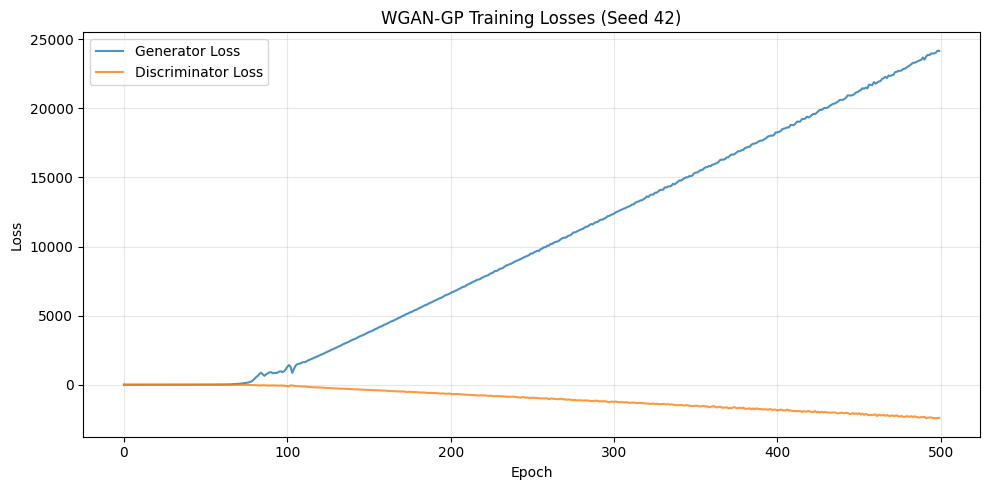


Generating synthetic data...
Synthetic label distribution: [0.69882525 0.30117475]
Saved: plots/gan/features_seed42.png


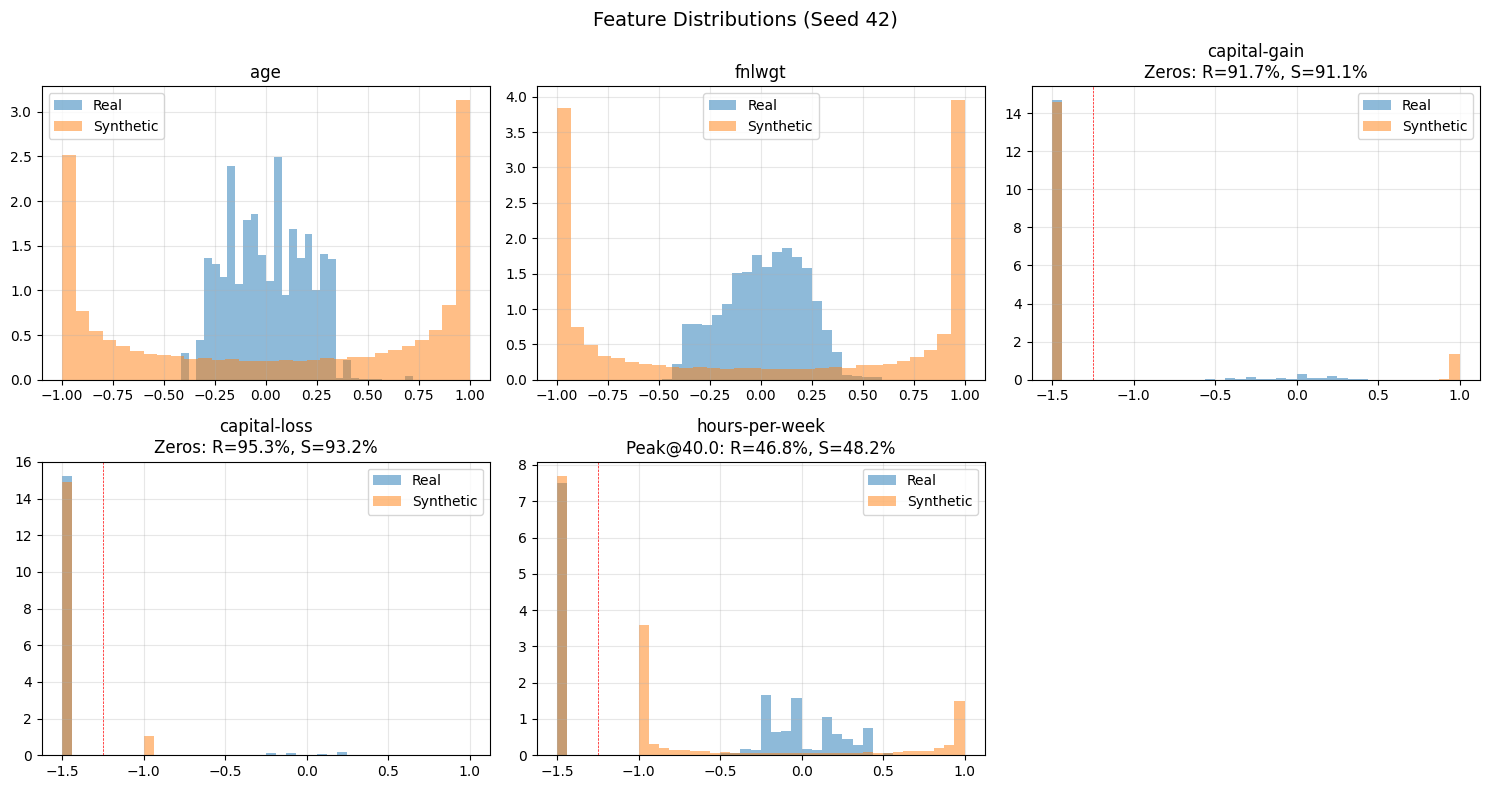

Saved: plots/gan/correlation_seed42.png


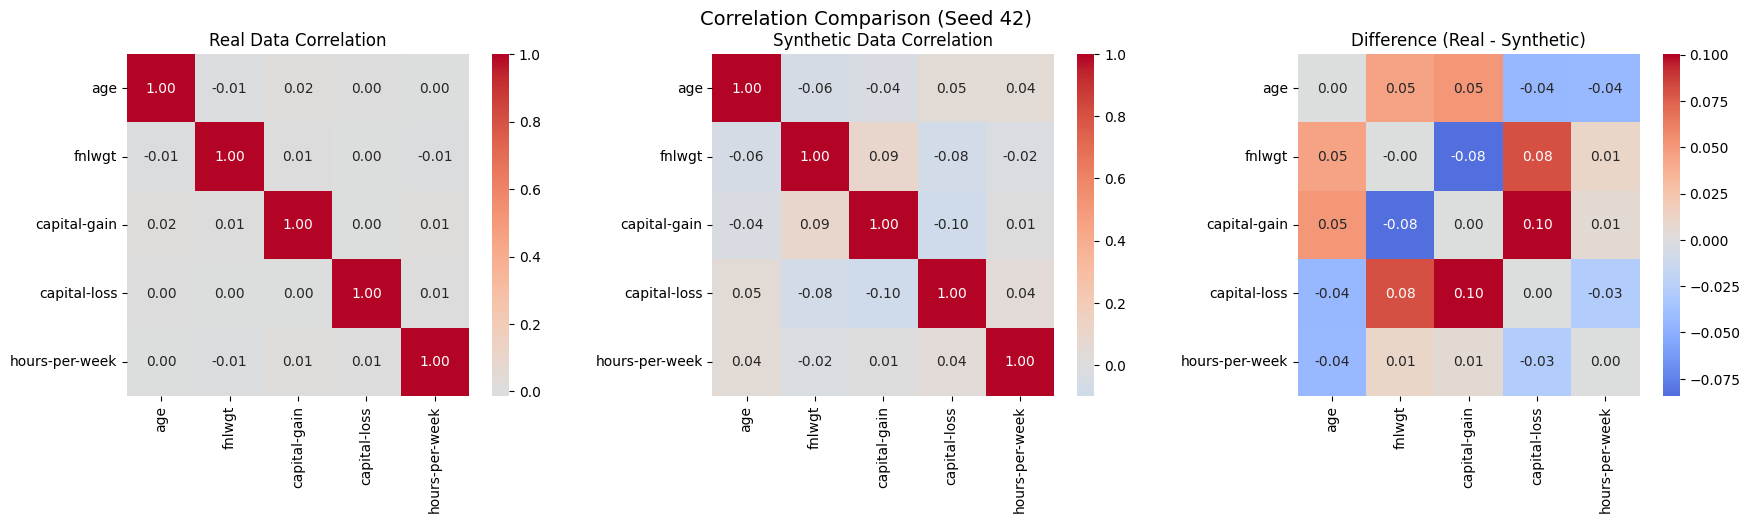

Saved: plots/gan/special_values_seed42.png


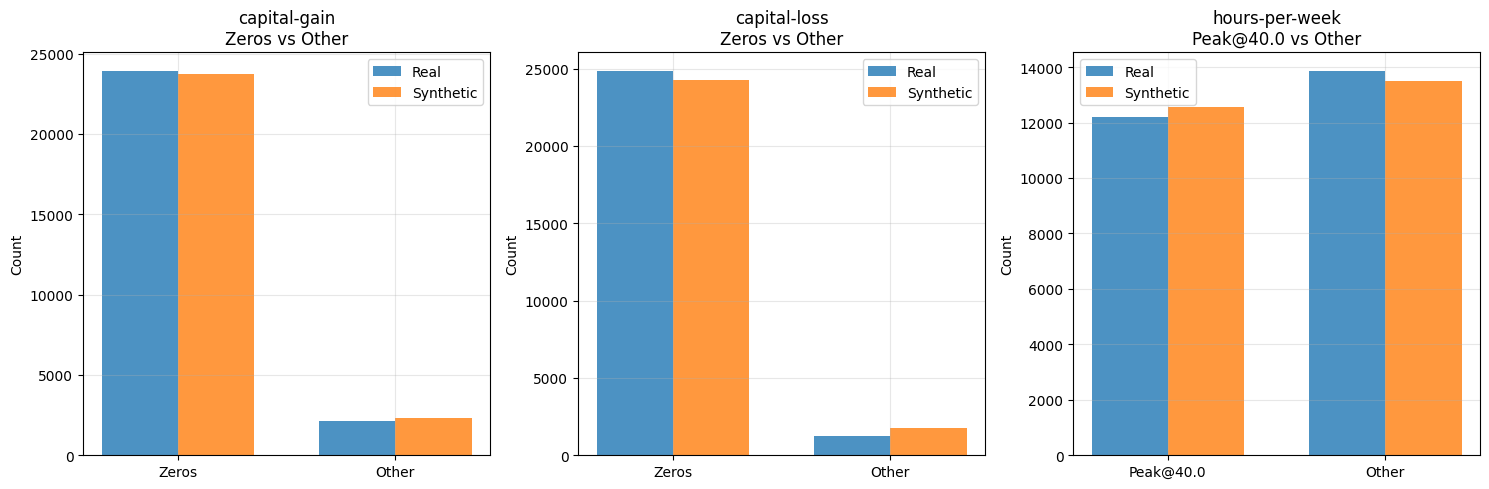


Computing metrics...

GAN Results (Seed 42):
Detection AUC: 1.0000 (+/- 0.0000) [Target: ~0.5]
Efficacy Ratio: 0.9550 [Target: ~1.0]
  - AUC (Real): 0.9073
  - AUC (Synthetic): 0.8665


In [17]:
# Run GAN with seed 42
print("="*60)
print("GAN Experiment (Seed 42) - Zero/Peak Inflation Handling")
print("="*60)

seed = 42
set_seed(seed)

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=seed, stratify=df[TARGET_COL]
)

preprocessor = DataPreprocessor(
    CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL,
    n_modes=N_MODES, rare_threshold=RARE_THRESHOLD
)
preprocessor.fit(train_df)

X_train, y_train = preprocessor.transform(train_df)
X_test, y_test = preprocessor.transform(test_df)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Special features: {preprocessor.get_special_cols()}")

generator, g_losses, d_losses = train_gan(
    X_train, preprocessor,
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr_g=LR_G,
    lr_d=LR_D,
    n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP,
    lambda_corr=LAMBDA_CORR,
    lambda_special=LAMBDA_SPECIAL,
    temperature=TEMPERATURE,
    dropout=DROPOUT,
    instance_noise=INSTANCE_NOISE,
    seed=seed,
    save_dir='plots/gan'
)

plot_training_losses(
    g_losses, d_losses,
    title=f"WGAN-GP Training Losses (Seed {seed})",
    save_path=f'plots/gan/losses_seed{seed}.png'
)

print("\nGenerating synthetic data...")
synthetic_data = generate_synthetic_data(generator, len(X_train), LATENT_DIM, device)

rf_labeler = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
rf_labeler.fit(X_train, y_train)
synthetic_labels = rf_labeler.predict(synthetic_data)
print(f"Synthetic label distribution: {np.bincount(synthetic_labels) / len(synthetic_labels)}")

plot_feature_distributions(
    X_train, synthetic_data, preprocessor,
    title=f"Feature Distributions (Seed {seed})",
    save_path=f'plots/gan/features_seed{seed}.png'
)

plot_correlation_matrices(
    X_train, synthetic_data, preprocessor,
    title=f"Correlation Comparison (Seed {seed})",
    save_path=f'plots/gan/correlation_seed{seed}.png'
)

plot_special_value_comparison(
    X_train, synthetic_data, preprocessor,
    save_path=f'plots/gan/special_values_seed{seed}.png'
)

print("\nComputing metrics...")
detection_auc, detection_std = compute_detection_metric(X_train, synthetic_data, seed=seed)
efficacy_ratio, auc_real, auc_synth = compute_efficacy_metric(
    X_train, y_train, synthetic_data, synthetic_labels, X_test, y_test, seed=seed
)

print(f"\n{'='*60}")
print(f"GAN Results (Seed {seed}):")
print(f"{'='*60}")
print(f"Detection AUC: {detection_auc:.4f} (+/- {detection_std:.4f}) [Target: ~0.5]")
print(f"Efficacy Ratio: {efficacy_ratio:.4f} [Target: ~1.0]")
print(f"  - AUC (Real): {auc_real:.4f}")
print(f"  - AUC (Synthetic): {auc_synth:.4f}")
print(f"{'='*60}")

gan_results_seed42 = {
    'seed': seed,
    'detection_auc': detection_auc,
    'detection_std': detection_std,
    'efficacy_ratio': efficacy_ratio,
    'auc_real': auc_real,
    'auc_synth': auc_synth,
    'g_losses': g_losses,
    'd_losses': d_losses
}


In [18]:
# Run cGAN with seed 42
print("="*60)
print("cGAN Experiment (Seed 42) - Zero/Peak Inflation Handling")
print("="*60)

seed = 42
set_seed(seed)

cgan_generator, cgan_g_losses, cgan_d_losses = train_cgan(
    X_train, y_train, preprocessor,
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr_g=LR_G,
    lr_d=LR_D,
    n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP,
    lambda_corr=LAMBDA_CORR,
    lambda_special=LAMBDA_SPECIAL,
    temperature=TEMPERATURE,
    dropout=DROPOUT,
    instance_noise=INSTANCE_NOISE,
    seed=seed,
    save_dir='plots/cgan'
)

plot_training_losses(
    cgan_g_losses, cgan_d_losses,
    title=f"cWGAN-GP Training Losses (Seed {seed})",
    save_path=f'plots/cgan/losses_seed{seed}.png'
)

print("\nGenerating conditional synthetic data...")
label_ratios = np.bincount(y_train) / len(y_train)
cgan_synthetic_data, cgan_synthetic_labels = generate_conditional_synthetic_data(
    cgan_generator, len(X_train), LATENT_DIM, label_ratios, device
)
print(f"Synthetic label distribution: {np.bincount(cgan_synthetic_labels) / len(cgan_synthetic_labels)}")

plot_feature_distributions(
    X_train, cgan_synthetic_data, preprocessor,
    title=f"cGAN Feature Distributions (Seed {seed})",
    save_path=f'plots/cgan/features_seed{seed}.png'
)

plot_correlation_matrices(
    X_train, cgan_synthetic_data, preprocessor,
    title=f"cGAN Correlation Comparison (Seed {seed})",
    save_path=f'plots/cgan/correlation_seed{seed}.png'
)

plot_special_value_comparison(
    X_train, cgan_synthetic_data, preprocessor,
    save_path=f'plots/cgan/special_values_seed{seed}.png'
)

print("\nComputing metrics...")
cgan_detection_auc, cgan_detection_std = compute_detection_metric(X_train, cgan_synthetic_data, seed=seed)
cgan_efficacy_ratio, cgan_auc_real, cgan_auc_synth = compute_efficacy_metric(
    X_train, y_train, cgan_synthetic_data, cgan_synthetic_labels, X_test, y_test, seed=seed
)

print(f"\n{'='*60}")
print(f"cGAN Results (Seed {seed}):")
print(f"{'='*60}")
print(f"Detection AUC: {cgan_detection_auc:.4f} (+/- {cgan_detection_std:.4f}) [Target: ~0.5]")
print(f"Efficacy Ratio: {cgan_efficacy_ratio:.4f} [Target: ~1.0]")
print(f"  - AUC (Real): {cgan_auc_real:.4f}")
print(f"  - AUC (Synthetic): {cgan_auc_synth:.4f}")
print(f"{'='*60}")

cgan_results_seed42 = {
    'seed': seed,
    'detection_auc': cgan_detection_auc,
    'detection_std': cgan_detection_std,
    'efficacy_ratio': cgan_efficacy_ratio,
    'auc_real': cgan_auc_real,
    'auc_synth': cgan_auc_synth,
    'g_losses': cgan_g_losses,
    'd_losses': cgan_d_losses
}


cGAN Experiment (Seed 42) - Zero/Peak Inflation Handling


Training cWGAN-GP:  10%|█         | 50/500 [05:36<49:25,  6.59s/it] 

Epoch [50/500] D_loss: -0.4307 G_loss: 6.1971


Training cWGAN-GP:  15%|█▌        | 76/500 [08:39<48:17,  6.83s/it]


KeyboardInterrupt: 

In [ ]:
# REMAINING RUNS: GAN experiments with seeds 123, 456 (seed 42 already done above)
REMAINING_SEEDS = [123, 456]

for seed in REMAINING_SEEDS:
    print(f"\n{'='*60}")
    print(f"GAN Experiment with seed {seed} (VGM)")
    print(f"{'='*60}")

    # Prepare data with new preprocessor for each seed
    preprocessor_seed = DataPreprocessor(
        CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL,
        n_modes=N_MODES, rare_threshold=RARE_THRESHOLD
    )
    X_train, X_test, y_train, y_test, preprocessor_seed = prepare_data(df, preprocessor_seed, seed=seed)

    # Train GAN with VGM architecture
    generator, g_losses, d_losses = train_gan(
        X_train, preprocessor_seed,
        latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        lr_g=LR_G, lr_d=LR_D,
        n_critic=N_CRITIC, lambda_gp=LAMBDA_GP,
        lambda_corr=LAMBDA_CORR,
        temperature=TEMPERATURE,
        dropout=DROPOUT,
        instance_noise=INSTANCE_NOISE, seed=seed
    )

    # Plot training losses
    plot_training_losses(g_losses, d_losses, f"WGAN-GP Training Losses (Seed {seed})")

    # Generate synthetic data
    X_synthetic = generate_synthetic_data(generator, len(X_train), LATENT_DIM, device)

    # Classifier-based label assignment
    label_clf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    label_clf.fit(X_train, y_train)
    y_synthetic = label_clf.predict(X_synthetic)

    print(f"Generated label distribution: {np.bincount(y_synthetic.astype(int)) / len(y_synthetic)}")
    print(f"Original label distribution: {np.bincount(y_train) / len(y_train)}")

    # Plot distributions
    plot_feature_distributions(X_train, X_synthetic, preprocessor_seed)
    plot_correlation_matrices(X_train, X_synthetic, preprocessor_seed)

    # Compute metrics
    detection_auc, detection_std = compute_detection_metric(X_train, X_synthetic, seed=seed)
    efficacy, auc_real, auc_synth = compute_efficacy_metric(
        X_train, y_train, X_synthetic, y_synthetic.astype(int), X_test, y_test, seed=seed
    )

    print(f"\nMetrics:")
    print(f"  Detection AUC: {detection_auc:.4f} (+/- {detection_std:.4f})")
    print(f"  Efficacy Ratio: {efficacy:.4f}")
    print(f"  AUC (Real): {auc_real:.4f}")
    print(f"  AUC (Synthetic): {auc_synth:.4f}")

    gan_results['detection_auc'].append(detection_auc)
    gan_results['efficacy_ratio'].append(efficacy)
    gan_results['auc_real'].append(auc_real)
    gan_results['auc_synthetic'].append(auc_synth)

# Summary
print("\n" + "="*60)
print("GAN RESULTS SUMMARY (Average over 3 seeds)")
print("="*60)
print(f"Detection AUC: {np.mean(gan_results['detection_auc']):.4f} (+/- {np.std(gan_results['detection_auc']):.4f})")
print(f"Efficacy Ratio: {np.mean(gan_results['efficacy_ratio']):.4f} (+/- {np.std(gan_results['efficacy_ratio']):.4f})")
print(f"AUC (Real): {np.mean(gan_results['auc_real']):.4f}")
print(f"AUC (Synthetic): {np.mean(gan_results['auc_synthetic']):.4f}")


In [ ]:
# REMAINING RUNS: cGAN experiments with seeds 123, 456 (seed 42 already done above)
REMAINING_SEEDS = [123, 456]

for seed in REMAINING_SEEDS:
    print(f"\n{'='*60}")
    print(f"cGAN Experiment with seed {seed} (VGM)")
    print(f"{'='*60}")

    # Prepare data with new preprocessor for each seed
    preprocessor_seed = DataPreprocessor(
        CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL,
        n_modes=N_MODES, rare_threshold=RARE_THRESHOLD
    )
    X_train, X_test, y_train, y_test, preprocessor_seed = prepare_data(df, preprocessor_seed, seed=seed)

    # Train cGAN with VGM architecture
    cgan_generator, cgan_g_losses, cgan_d_losses = train_cgan(
        X_train, y_train, preprocessor_seed,
        latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        lr_g=LR_G, lr_d=LR_D,
        n_critic=N_CRITIC, lambda_gp=LAMBDA_GP,
        lambda_corr=LAMBDA_CORR,
        temperature=TEMPERATURE,
        dropout=DROPOUT,
        instance_noise=INSTANCE_NOISE, seed=seed
    )

    # Plot training losses
    plot_training_losses(cgan_g_losses, cgan_d_losses, f"cWGAN-GP Training Losses (Seed {seed})")

    # Generate conditional synthetic data with original label ratios
    label_ratios = np.bincount(y_train) / len(y_train)
    X_synthetic, y_synthetic = generate_conditional_synthetic_data(
        cgan_generator, len(X_train), LATENT_DIM, label_ratios, device
    )

    print(f"Generated label distribution: {np.bincount(y_synthetic.astype(int)) / len(y_synthetic)}")
    print(f"Original label distribution: {np.bincount(y_train) / len(y_train)}")

    # Plot distributions
    plot_feature_distributions(X_train, X_synthetic, preprocessor_seed)
    plot_correlation_matrices(X_train, X_synthetic, preprocessor_seed)

    # Compute metrics
    detection_auc, detection_std = compute_detection_metric(X_train, X_synthetic, seed=seed)
    efficacy, auc_real, auc_synth = compute_efficacy_metric(
        X_train, y_train, X_synthetic, y_synthetic.astype(int), X_test, y_test, seed=seed
    )

    print(f"\nMetrics:")
    print(f"  Detection AUC: {detection_auc:.4f} (+/- {detection_std:.4f})")
    print(f"  Efficacy Ratio: {efficacy:.4f}")
    print(f"  AUC (Real): {auc_real:.4f}")
    print(f"  AUC (Synthetic): {auc_synth:.4f}")

    cgan_results['detection_auc'].append(detection_auc)
    cgan_results['efficacy_ratio'].append(efficacy)
    cgan_results['auc_real'].append(auc_real)
    cgan_results['auc_synthetic'].append(auc_synth)

# Summary
print("\n" + "="*60)
print("cGAN RESULTS SUMMARY (Average over 3 seeds)")
print("="*60)
print(f"Detection AUC: {np.mean(cgan_results['detection_auc']):.4f} (+/- {np.std(cgan_results['detection_auc']):.4f})")
print(f"Efficacy Ratio: {np.mean(cgan_results['efficacy_ratio']):.4f} (+/- {np.std(cgan_results['efficacy_ratio']):.4f})")
print(f"AUC (Real): {np.mean(cgan_results['auc_real']):.4f}")
print(f"AUC (Synthetic): {np.mean(cgan_results['auc_synthetic']):.4f}")


---

## 10. Final Comparison and Analysis

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['GAN', 'cGAN'],
    'Detection AUC (mean)': [np.mean(gan_results['detection_auc']), np.mean(cgan_results['detection_auc'])],
    'Detection AUC (std)': [np.std(gan_results['detection_auc']), np.std(cgan_results['detection_auc'])],
    'Efficacy Ratio (mean)': [np.mean(gan_results['efficacy_ratio']), np.mean(cgan_results['efficacy_ratio'])],
    'Efficacy Ratio (std)': [np.std(gan_results['efficacy_ratio']), np.std(cgan_results['efficacy_ratio'])],
})

print("\n" + "="*60)
print("FINAL COMPARISON: GAN vs cGAN")
print("="*60)
print(comparison_df.to_string(index=False))
print("\nNote: For Detection AUC, lower is better (closer to 0.5 means indistinguishable)")
print("      For Efficacy Ratio, higher is better (closer to 1.0 means useful substitute)")

In [ ]:
# Visualization of comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Detection AUC
models = ['GAN', 'cGAN']
detection_means = [np.mean(gan_results['detection_auc']), np.mean(cgan_results['detection_auc'])]
detection_stds = [np.std(gan_results['detection_auc']), np.std(cgan_results['detection_auc'])]

axes[0].bar(models, detection_means, yerr=detection_stds, capsize=5, color=['steelblue', 'coral'])
axes[0].axhline(y=0.5, color='green', linestyle='--', label='Ideal (0.5)')
axes[0].set_ylabel('Detection AUC')
axes[0].set_title('Detection Metric (Lower is Better)')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Efficacy Ratio
efficacy_means = [np.mean(gan_results['efficacy_ratio']), np.mean(cgan_results['efficacy_ratio'])]
efficacy_stds = [np.std(gan_results['efficacy_ratio']), np.std(cgan_results['efficacy_ratio'])]

axes[1].bar(models, efficacy_means, yerr=efficacy_stds, capsize=5, color=['steelblue', 'coral'])
axes[1].axhline(y=1.0, color='green', linestyle='--', label='Ideal (1.0)')
axes[1].set_ylabel('Efficacy Ratio')
axes[1].set_title('Efficacy Metric (Higher is Better)')
axes[1].legend()
axes[1].set_ylim(0, 1.2)

plt.tight_layout()
plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 11. Conclusions

### Key Improvements Implemented

We implemented several critical improvements to the baseline GAN architecture:

1. **Gumbel-Softmax with Straight-Through Estimator**
   - Problem: Soft categorical probabilities (e.g., [0.3, 0.5, 0.2]) are trivially distinguishable from hard one-hot real data
   - Solution: Gumbel-Softmax produces hard one-hot outputs in forward pass while allowing gradients to flow in backward pass

2. **WGAN-GP (Wasserstein Loss with Gradient Penalty)**
   - Problem: BCE loss with Sigmoid causes vanishing gradients when discriminator becomes confident
   - Solution: Wasserstein loss provides meaningful gradients throughout training; gradient penalty enforces 1-Lipschitz constraint

3. **Log Transform for Skewed Features**
   - Problem: Features like `capital-gain` and `capital-loss` have ~90% zeros, which MinMax scaling compresses poorly
   - Solution: log1p transform spreads the distribution more evenly before scaling

4. **Classifier-Based Label Assignment for GAN**
   - Problem: Random label assignment destroys feature-label correlations, making synthetic data useless for training classifiers
   - Solution: Train a classifier on real data and use it to predict labels for synthetic samples

5. **Spectral Normalization and TTUR**
   - Spectral normalization stabilizes the discriminator
   - Different learning rates (TTUR) help balance G and D training

### Analysis of Results

**Detection Metric:**
- A detection AUC close to 0.5 indicates synthetic data is indistinguishable from real data
- Lower values suggest the GAN successfully learned the data distribution

**Efficacy Metric:**
- An efficacy ratio close to 1.0 indicates synthetic data preserves useful patterns for downstream tasks
- Higher values mean better utility as a substitute for real data

### Limitations and Future Work

- **Mode-specific normalization**: CTGAN's VGM approach could further improve continuous feature handling
- **Attention mechanisms**: Could help capture complex feature correlations
- **Diffusion models**: TabDDPM currently achieves state-of-the-art results on tabular data
- **Privacy considerations**: Current metrics don't evaluate privacy preservation

### References

1. Xu, L. et al. "Modeling Tabular data using Conditional GAN" NeurIPS 2019 - CTGAN
2. Zhao, Z. et al. "CTAB-GAN+: Enhancing Tabular Data Synthesis" - Improvements on CTGAN
3. Jang, E. et al. "Categorical Reparameterization with Gumbel-Softmax" ICLR 2017
4. Gulrajani, I. et al. "Improved Training of Wasserstein GANs" NeurIPS 2017 - WGAN-GP